In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import pandas_datareader as web
import datetime as dt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Preprocessing

EDA

In [31]:
import pandas as pd
import string

# Load data
trainData = pd.read_csv("train.csv")
testData  = pd.read_csv("test.csv")

# -----------------------------------------
# FUNCTION to clean categorical text
# -----------------------------------------
def clean_text_columns(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    punct_table = str.maketrans('', '', string.punctuation)

    for col in cat_cols:
        if col == 'trip_id':
            continue
        df[col] = df[col].apply(
            lambda x:
                x.translate(punct_table)
                 .replace(" ", "_")
                 .lower()
                 .strip()
            if isinstance(x, str) else x   # KEEP NaN AS IT IS
        )
    return df

# -----------------------------------------
# Apply to both train & test
# -----------------------------------------
trainData = clean_text_columns(trainData)
testData  = clean_text_columns(testData)
combined = pd.concat([trainData, testData], axis=0)
for col in testData.columns:
    if (combined[col].nunique() != trainData[col].nunique()):
        print(col)


trip_id
country
num_males
mainland_stay_nights
island_stay_nights


In [15]:
print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      12654 non-null  object 
 1   country                      12424 non-null  object 
 2   age_group                    12646 non-null  object 
 3   travel_companions            11917 non-null  object 
 4   num_females                  12652 non-null  float64
 5   num_males                    12650 non-null  float64
 6   main_activity                12526 non-null  object 
 7   visit_purpose                12654 non-null  object 
 8   is_first_visit               12555 non-null  object 
 9   mainland_stay_nights         12654 non-null  int64  
 10  island_stay_nights           12654 non-null  int64  
 11  tour_type                    12654 non-null  object 
 12  intl_transport_included      12507 non-null  object 
 13  info_source     

Removing Null Values

In [32]:
import pandas as pd

def drop_rows_for_low_nan_columns(df, threshold=50):
    for col in df.columns:
        nan_count = df[col].isna().sum()

        # If column has fewer than threshold NaNs → drop those rows
        if nan_count < threshold and nan_count > 0:
            df = df.dropna(subset=[col])

    return df

# Apply to both train and test
trainData = drop_rows_for_low_nan_columns(trainData, threshold=50)

def removeNullValues(data):
    replace_numeric_null = {}
    replace_cat_null = {}
    # Identify features
    numeric_features = [c for c in data.select_dtypes(include=['float64','int64']).columns 
                    if c != "spend_category"]

    categorical_features = [c for c in data.select_dtypes(exclude=['float64','int64']).columns
                    if c != "spend_category"]
    for col in numeric_features:
        replace_numeric_null[col] = data[col].median()
    for col in categorical_features:
        count = data[col].isna().sum()
        if count <= 1000:
            replace_cat_null[col] = data[col].mode()[0]
        else :
            replace_cat_null[col] = 'none'
            print(col)

    return replace_cat_null, replace_numeric_null

def apply_null_remove(data, cat, num):
    numeric_features = [c for c in data.select_dtypes(include=['float64','int64']).columns 
                    if c != "spend_category"]

    categorical_features = [c for c in data.select_dtypes(exclude=['float64','int64']).columns
                    if c != "spend_category"]
    for col in numeric_features:
        data[col] = data[col].fillna(num[col])
    for col in categorical_features:
        data[col] = data[col].fillna(cat[col])

cat, num = removeNullValues(trainData)

apply_null_remove(trainData, cat, num)
apply_null_remove(testData, cat, num)

country_freq = trainData['country'].value_counts(normalize=True)

# trainData['country'] = trainData['country'].map(country_freq)
# testData['country'] = testData['country'].map(country_freq).fillna(0)

days_booked_before_trip
arrival_weather
has_special_requirements


Remove the ID column from train and test data

In [33]:
trainData = trainData.drop('trip_id', axis=1)
testId = testData['trip_id']
testData = testData.drop('trip_id', axis=1)

trainData['num_females'] = trainData['num_females'].astype(int)
testData['num_females'] = testData['num_females'].astype(int)
trainData['num_males'] = trainData['num_males'].astype(int)
testData['num_males'] = testData['num_males'].astype(int)

trainData['number_of_visitors'] = trainData['num_males'] + trainData['num_females']
testData['number_of_visitors'] = testData['num_males'] + testData['num_females']

trainData = trainData.drop(columns=['num_males', 'num_females'])
testData = testData.drop(columns=['num_males', 'num_females'])

def encode_stay_nights(series):
    return (
        series
        .apply(lambda x:
               0 if x <= 10 else
               1 if x <= 50 else
               2 if x <= 100 else
               3)
    )

# Mainland stay nights encoding
trainData['mainland_stay_nights'] = encode_stay_nights(trainData['mainland_stay_nights'])
testData['mainland_stay_nights']  = encode_stay_nights(testData['mainland_stay_nights'])

# Island stay nights encoding
trainData['island_stay_nights'] = encode_stay_nights(trainData['island_stay_nights'])
testData['island_stay_nights']  = encode_stay_nights(testData['island_stay_nights'])

In [7]:
print(trainData.info())
print(trainData['mainland_stay_nights'].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 12606 entries, 0 to 12653
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      12606 non-null  object 
 1   age_group                    12606 non-null  object 
 2   travel_companions            12606 non-null  object 
 3   main_activity                12606 non-null  object 
 4   visit_purpose                12606 non-null  object 
 5   is_first_visit               12606 non-null  object 
 6   mainland_stay_nights         12606 non-null  int64  
 7   island_stay_nights           12606 non-null  int64  
 8   tour_type                    12606 non-null  object 
 9   intl_transport_included      12606 non-null  object 
 10  info_source                  12606 non-null  object 
 11  accomodation_included        12606 non-null  object 
 12  food_included                12606 non-null  object 
 13  domestic_transport_in

More EDA

In [24]:
numeric_features = list(trainData.iloc[:, :-1].select_dtypes(include=['float64', 'int64']).columns)
categorical_features = list(trainData.select_dtypes(exclude=['float64', 'int64']).columns)

# target = 'spend_category'

# for col in categorical_features:
#     plt.figure(figsize=(8, 4))

#     sns.countplot(
#         data=trainData,
#         x=col,
#         hue=target
#     )

#     plt.title(f"{col} vs {target} (countplot)")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()
import pandas as pd
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# for col1 in categorical_features:
#   for col2 in categorical_features:
#     if col1 != col2:
#       if cramers_v(trainData[col1], trainData[col2]) > 0.7:
#         print(col1, " " , col2, " ", cramers_v(trainData[col1], trainData[col2]))

trainData = trainData.drop(columns=['accomodation_included',
                                    'food_included',
                                    'domestic_transport_included'])
testData = testData.drop(columns=['accomodation_included',
                                    'food_included',
                                    'domestic_transport_included'])
print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12606 entries, 0 to 12653
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   12606 non-null  object 
 1   age_group                 12606 non-null  object 
 2   travel_companions         12606 non-null  object 
 3   main_activity             12606 non-null  object 
 4   visit_purpose             12606 non-null  object 
 5   is_first_visit            12606 non-null  object 
 6   mainland_stay_nights      12606 non-null  int64  
 7   island_stay_nights        12606 non-null  int64  
 8   tour_type                 12606 non-null  object 
 9   intl_transport_included   12606 non-null  object 
 10  info_source               12606 non-null  object 
 11  sightseeing_included      12606 non-null  object 
 12  guide_included            12606 non-null  object 
 13  insurance_included        12606 non-null  object 
 14  days_booked

Encode Categorical Features

In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Define the new binary columns
def encode_travel(df):
    df['with_children'] = df['travel_companions'].isin(
        ['With Spouse and Children', 'With Children']
    ).astype(int)

    df['with_spouse'] = df['travel_companions'].isin(
        ['With Spouse and Children', 'With Spouse']
    ).astype(int)

    df['with_friends'] = df['travel_companions'].isin(
        ['With Other Friends/Relatives']
    ).astype(int)

# Apply encoding
encode_travel(trainData)
encode_travel(testData)

# Drop the original column
trainData = trainData.drop(columns=['travel_companions'])
testData  = testData.drop(columns=['travel_companions'])

trainData['visit_purpose'] = trainData['visit_purpose'].replace('Widlife Tourism', 'Wildlife Tourism')
testData['visit_purpose'] = testData['visit_purpose'].replace('Widlife Tourism', 'Wildlife Tourism')
trainData['main_activity'] = trainData['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')
testData['main_activity'] = testData['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')

# ---------------------------------------------------------
# 1. Clean whitespace in categorical columns
# ---------------------------------------------------------
for col in ['age_group', 'days_booked_before_trip', 'total_trip_days']:
    trainData[col] = trainData[col].astype(str).str.strip()
    testData[col]  = testData[col].astype(str).str.strip()

# ---------------------------------------------------------
# 2. Extract categorical columns
# ---------------------------------------------------------
cat_cols = trainData.select_dtypes(include=['object']).columns.tolist()

# Remove manually-encoded ordinal columns
protected = ['age_group', 'days_booked_before_trip', 'total_trip_days']
cat_cols = [c for c in cat_cols if c not in protected]

# (note: travel_companions was removed above)


# ---------------------------------------------------------
# 3. Process categorical columns
# ---------------------------------------------------------
ohe_cols = []
for col in cat_cols:
    if trainData[col].nunique() <= 2 and testData[col].nunique() <= 2:
        le = LabelEncoder()
        all_vals = pd.concat([trainData[col], testData[col]], axis=0)
        le.fit(all_vals)

        trainData[col] = le.transform(trainData[col])
        testData[col]  = le.transform(testData[col])
    else:
        ohe_cols.append(col)

# ---------------------------------------------------------
# 4. One-hot encode multi-category columns
# ---------------------------------------------------------
combined = pd.concat([trainData, testData], axis=0)
combined = pd.get_dummies(combined, columns=ohe_cols, drop_first=False)

# Split back
trainData = combined.iloc[:len(trainData)].copy()
testData  = combined.iloc[len(trainData):].copy()

# ---------------------------------------------------------
# 5. Ordinal maps
# ---------------------------------------------------------
age_map = {
    '<18': 0,
    '18-24': 1,
    '25-44': 2,
    '45-64': 3,
    '65+': 4,
    'none': -1
}

days_map = {v:i for i,v in enumerate(['1-7','8-14','15-30','31-60','61-90','90+','none'])}
trip_days_map = {v:i for i,v in enumerate(['1-6','7-14','15-30','30+','none'])}

# ---------------------------------------------------------
# 6. Apply mapping (safe)
# ---------------------------------------------------------
for col, mapping in [
    ('age_group', age_map),
    ('days_booked_before_trip', days_map),
    ('total_trip_days', trip_days_map)
]:
    trainData[col] = trainData[col].map(mapping).fillna(-1).astype(int)
    testData[col]  = testData[col].map(mapping).fillna(-1).astype(int)

# ---------------------------------------------------------
# Done
# ---------------------------------------------------------
# print(trainData.info())
# print(testData.info())
# for col in trainData.columns:
#     print(col, trainData[col].unique())
# print(trainData)

Split into X and y

In [35]:
X = trainData.drop(columns=['spend_category'])
y = trainData['spend_category']

Scale featues

In [36]:
if 'spend_category' in testData.columns:
    testData = testData.drop(columns=['spend_category'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(testData)

Logistic regression

In [28]:
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Fixed logistic parameters (cleaned)
# -------------------------
best_lr_params = {
    "C": 0.1,
    "penalty": "l2",
    "solver": "lbfgs",
    "max_iter": 5000
}

base_lr = LogisticRegression(**best_lr_params)

# -------------------------
# Bagging classifier
# -------------------------
bag = BaggingClassifier(
    estimator=base_lr,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# -------------------------
# Bagging parameter grid
# -------------------------
param_grid = {
    "n_estimators": [20],
    "max_samples": [0.6],
    "max_features": [1.0]
}

grid = GridSearchCV(
    estimator=bag,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_scaled, y)

print("\nBest Bagging Params:")
print(grid.best_params_)

print("\nBest CV Accuracy:", grid.best_score_)

# -------------------------
# Evaluate training performance
# -------------------------
best_bag = grid.best_estimator_

train_pred = best_bag.predict(X_scaled)
print("\nTraining Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report:\n", classification_report(y, train_pred))

# -------------------------
# Test predictions
# -------------------------
test_pred = best_bag.predict(test_scaled)

submission = pd.DataFrame({
    "trip_id": testId,
    "spend_category": test_pred
})

submission.to_csv("bagging_logistic_fixedLR_gridsearch.csv", index=False)
print("Saved: bagging_logistic_fixedLR_gridsearch.csv")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_features=1.0, max_samples=0.6, n_estimators=20; total time=   2.1s
[CV] END .max_features=1.0, max_samples=0.6, n_estimators=20; total time=   2.1s
[CV] END .max_features=1.0, max_samples=0.6, n_estimators=20; total time=   2.1s
[CV] END .max_features=1.0, max_samples=0.6, n_estimators=20; total time=   2.1s
[CV] END .max_features=1.0, max_samples=0.6, n_estimators=20; total time=   2.1s

Best Bagging Params:
{'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 20}

Best CV Accuracy: 0.7397268181219075

Training Accuracy: 0.7486117721719816

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.85      0.84      6237
         1.0       0.68      0.72      0.70      4907
         2.0       0.66      0.38      0.49      1462

    accuracy                           0.75     12606
   macro avg       0.72      0.65      0.67     12606
weighted avg       0.74 

SVM

In [48]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Define parameter grid
# -------------------------
param_grid = {
    'C': [0.1, 1, 5, 10, 20],
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# -------------------------
# Grid Search with 5-fold CV
# -------------------------
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_scaled, y)

print("\nBest Parameters from Grid Search:")
print(grid.best_params_)

print("\nBest CV Accuracy:", grid.best_score_)

# -------------------------
# Train best model
# -------------------------
best_model = grid.best_estimator_

# -------------------------
# Evaluate on training data
# -------------------------
train_pred = best_model.predict(X_scaled)

print("\nTraining Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report (Training Data):\n")
print(classification_report(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = best_model.predict(test_scaled)

# -------------------------
# Create submission file
# -------------------------
submission = pd.DataFrame({
    'trip_id': testId,
    'spend_category': test_pred
})

submission.to_csv("svm_gridsearch.csv", index=False)
print("svm_gridsearch.csv created!")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  22.6s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  23.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  23.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  23.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  23.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  23.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  23.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  23.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  23.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  23.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  24.2s
[CV] END ......................C=0.1, gamma=0.0

/Users/kunaljindal/Desktop/Machine Learning/Project/Travel_Behaviour/travel-behavior-insights/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=  20.6s
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=  20.6s
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=  21.0s
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=  21.2s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  23.5s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  24.6s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  24.5s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=  21.7s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  25.6s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  25.1s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=  21.4s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=  23.8s
[CV] END ...................

Random Forest

In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Grid search parameters
# -------------------------
param_grid = {
    "n_estimators": [1000],
}

# -------------------------
# Grid Search
# -------------------------
rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_scaled, y)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

model = grid.best_estimator_

# -------------------------
# Training performance
# -------------------------
train_pred = model.predict(X_scaled)
print("\nTraining Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report (Training Data):\n")
print(classification_report(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = model.predict(test_scaled)

# -------------------------
# Create submission file
# -------------------------
submission = pd.DataFrame({
    "trip_id": testId,
    "spend_category": test_pred
})

submission.to_csv("randomForest_gridsearch.csv", index=False)
print("randomForest_gridsearch.csv created!")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

Neural Ntwk

In [37]:
# !pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# -------------------------
# Device (GPU if available)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# Convert numpy → tensors
# -------------------------
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

# Dataloaders (mini-batch)
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# -------------------------
# Define MLP model
# -------------------------
class MLP(nn.Module):
    def __init__(self, hidden_layers, activation_fn, input_dim, output_dim):
        super().__init__()

        layers = []
        prev = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(activation_fn())
            prev = h

        layers.append(nn.Linear(prev, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# -------------------------
# Activation mapping
# -------------------------
activation_map = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
    "logistic": nn.Sigmoid
}

# -------------------------
# Hyperparameter grid
# -------------------------
# param_grid = {
#     "hidden_layer_sizes": [(64, 32), (128, 64)],
#     "activation": ["relu"],
#     "solver": ["adam", "sgd"],
#     "learning_rate_init": [0.001, 0.01],
#     "alpha": [0.0001, 0.0005],
# }
param_grid = {'hidden_layer_sizes': [(128, 512, 1024)], 'activation': ['relu'], 'solver': ['adam'], 'learning_rate_init': [0.001], 'alpha': [0.0001]}


# -------------------------
# Training function (GPU)
# -------------------------
def train_model(model, optimizer, criterion, early_stopping=True, patience=20):
    model.train()
    best_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(200):   # fewer epochs required because GPU + mini-batch
        total_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Early stopping check
        avg_loss = total_loss / len(train_loader)
        if early_stopping:
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_state = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                break

    if early_stopping and best_state is not None:
        model.load_state_dict(best_state)

    return best_loss

# -------------------------
# Manual Grid Search (GPU)
# -------------------------
best_score = -1
best_params = None
best_model = None

input_dim = X_scaled.shape[1]
output_dim = len(np.unique(y))

for hidden in param_grid["hidden_layer_sizes"]:
    for activation in param_grid["activation"]:
        for solver in param_grid["solver"]:
            for lr in param_grid["learning_rate_init"]:
                for wd in param_grid["alpha"]:

                    act_fn = activation_map[activation]

                    model = MLP(hidden, act_fn, input_dim, output_dim).to(device)

                    if solver == "adam":
                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    else:
                        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

                    criterion = nn.CrossEntropyLoss()

                    train_model(model, optimizer, criterion, early_stopping=True)

                    # Evaluate on full training set
                    model.eval()
                    with torch.no_grad():
                        preds = torch.argmax(model(X_tensor.to(device)), dim=1).cpu().numpy()
                        acc = accuracy_score(y, preds)

                    if acc > best_score:
                        best_score = acc
                        best_params = {
                            "hidden_layer_sizes": hidden,
                            "activation": activation,
                            "solver": solver,
                            "learning_rate_init": lr,
                            "alpha": wd
                        }
                        best_model = model

                        print("\nNew Best Score:", best_score)
                        print("Params:", best_params)
                        print("-" * 50)

# -------------------------
# Final training accuracy
# -------------------------
print("\nFinal Best Training Accuracy:", best_score)
print("Best Params:", best_params)

# -------------------------
# Predict test data
# -------------------------
best_model.eval()
with torch.no_grad():
    test_pred = torch.argmax(best_model(test_tensor.to(device)), dim=1).cpu().numpy()

# -------------------------
# Create submission
# -------------------------
submission = pd.DataFrame({
    "trip_id": testId,
    "spend_category": test_pred
})

submission.to_csv("pytorch_mlp_gpu_gridsearch.csv", index=False)
print("pytorch_mlp_gpu_gridsearch.csv created!")

Using device: cpu

New Best Score: 0.9769157544026654
Params: {'hidden_layer_sizes': (128, 512, 1024), 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.001, 'alpha': 0.0001}
--------------------------------------------------

Final Best Training Accuracy: 0.9769157544026654
Best Params: {'hidden_layer_sizes': (128, 512, 1024), 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.001, 'alpha': 0.0001}
pytorch_mlp_gpu_gridsearch.csv created!


nn with bagging

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from collections import Counter

# -------------------------
# Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# Convert numpy → tensors
# -------------------------
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_tensor, y_tensor)

# -------------------------
# Base MLP Model
# -------------------------
class MLP(nn.Module):
    def __init__(self, hidden_layers, activation_fn, input_dim, output_dim):
        super().__init__()

        layers = []
        prev = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(activation_fn())
            prev = h

        layers.append(nn.Linear(prev, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# -------------------------
# Training function for each NN
# -------------------------
def train_single_model(model, loader, lr=0.001, wd=1e-4, epochs=40):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    return model

# -------------------------
# Bagging Ensemble
# -------------------------
def bagging_ensemble(
    n_estimators=20,
    sample_ratio=0.6,
    batch_size=256,
    hidden=(128, 64),
    activation="relu",
    lr=0.001,
    weight_decay=0.0001,
):
    activation_map = {
        "relu": nn.ReLU,
        "tanh": nn.Tanh,
        "logistic": nn.Sigmoid
    }

    act_fn = activation_map[activation]

    models = []
    input_dim = X_tensor.shape[1]
    output_dim = len(np.unique(y_tensor.numpy()))

    N = len(train_dataset)
    sample_size = int(sample_ratio * N)

    for i in range(n_estimators):
        # Bootstrap sample
        indices = np.random.choice(N, size=sample_size, replace=True)
        bootstrap_ds = Subset(train_dataset, indices)
        loader = DataLoader(bootstrap_ds, batch_size=batch_size, shuffle=True)

        # Create model
        model = MLP(hidden, act_fn, input_dim, output_dim).to(device)

        print(f"Training model {i+1}/{n_estimators} ...")
        train_single_model(model, loader, lr, weight_decay)
        models.append(model)

    return models

# -------------------------
# Voting prediction
# -------------------------
def predict_ensemble(models, X):
    preds = []
    X = X.to(device)

    for m in models:
        m.eval()
        with torch.no_grad():
            p = torch.argmax(m(X), dim=1).cpu().numpy()
            preds.append(p)

    preds = np.array(preds)   # shape: (n_estimators, n_samples)
    final_pred = []

    for j in range(preds.shape[1]):
        label = Counter(preds[:, j]).most_common(1)[0][0]
        final_pred.append(label)

    return np.array(final_pred)

# ----------------------------------------------------
# Train the Bagging Ensemble
# ----------------------------------------------------
models = bagging_ensemble(
    n_estimators=30,
    hidden=(512, 1024, 128),
    activation="relu",
    sample_ratio=0.6,
    batch_size=256,
    lr=0.001,
    weight_decay=0.0001
)

# -------------------------
# Training accuracy
# -------------------------
train_pred = predict_ensemble(models, X_tensor)
print("\nTraining Accuracy:", accuracy_score(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = predict_ensemble(models, test_tensor)

# -------------------------
# Create submission
# -------------------------
submission = pd.DataFrame({
    "trip_id": testId,
    "spend_category": test_pred
})

submission.to_csv("pytorch_bagging_nn.csv", index=False)
print("pytorch_bagging_nn.csv created!")

Using device: cpu
Training model 1/30 ...
Training model 2/30 ...
Training model 3/30 ...
Training model 4/30 ...
Training model 5/30 ...
Training model 6/30 ...
Training model 7/30 ...
Training model 8/30 ...
Training model 9/30 ...
Training model 10/30 ...
Training model 11/30 ...
Training model 12/30 ...
Training model 13/30 ...
Training model 14/30 ...
Training model 15/30 ...
Training model 16/30 ...
Training model 17/30 ...
Training model 18/30 ...
Training model 19/30 ...
Training model 20/30 ...
Training model 21/30 ...
Training model 22/30 ...
Training model 23/30 ...
Training model 24/30 ...
Training model 25/30 ...
Training model 26/30 ...
Training model 27/30 ...
Training model 28/30 ...
Training model 29/30 ...
Training model 30/30 ...

Training Accuracy: 0.9066317626527051
pytorch_bagging_nn.csv created!


CatBoost

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Train the model
# -------------------------
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    verbose=False
)

model.fit(X_scaled, y)

# -------------------------
# Evaluate on training data
# -------------------------
train_pred = model.predict(X_scaled)
train_pred = train_pred.reshape(-1)  # flatten predictions

print("Training Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report (Training Data):\n")
print(classification_report(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(-1)

# -------------------------
# Create submission file
# -------------------------
submission = pd.DataFrame({
    'trip_id': testId,
    'spend_category': test_pred
})

submission.to_csv("catboost1.csv", index=False)
print("catboost.csv created!")

Training Accuracy: 0.7911332385016595

Classification Report (Training Data):

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      6245
         1.0       0.72      0.79      0.75      4945
         2.0       0.79      0.44      0.56      1464

    accuracy                           0.79     12654
   macro avg       0.79      0.70      0.73     12654
weighted avg       0.79      0.79      0.79     12654

catboost.csv created!


K nearest Neighbours

In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Define parameter grid
# -------------------------
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]   # p=1→Manhattan, p=2→Euclidean
}

# -------------------------
# Grid Search with 5-fold CV
# -------------------------
grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

print("\nBest Parameters from Grid Search:")
print(grid.best_params_)

print("\nBest CV Accuracy:", grid.best_score_)

# -------------------------
# Train best model
# -------------------------
best_model = grid.best_estimator_

# -------------------------
# Evaluate on training data
# -------------------------
train_pred = best_model.predict(X_scaled)

print("\nTraining Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report (Training Data):\n")
print(classification_report(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = best_model.predict(test_scaled)

# -------------------------
# Create submission file
# -------------------------
submission = pd.DataFrame({
    'trip_id': testId,
    'spend_category': test_pred
})

submission.to_csv("knn_gridsearch.csv", index=False)
print("knn_gridsearch.csv created!")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.5s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.7s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.6s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.4s
[CV] END metric=euclidean, n_neighbors=3, p=2, weights=uniform; total time=   0.4s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.6s
[CV] END metric=eucl

/Users/kunaljindal/Desktop/Machine Learning/Project/Travel_Behaviour/travel-behavior-insights/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Training Accuracy: 0.5807649755018176

Classification Report (Training Data):

              precision    recall  f1-score   support

         0.0       0.89      0.63      0.74      6245
         1.0       0.52      0.46      0.49      4945
         2.0       0.29      0.75      0.42      1464

    accuracy                           0.58     12654
   macro avg       0.57      0.62      0.55     12654
weighted avg       0.68      0.58      0.61     12654



/Users/kunaljindal/Desktop/Machine Learning/Project/Travel_Behaviour/travel-behavior-insights/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


knn_gridsearch.csv created!


Naive Bayes

In [10]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# -------------------------
# Parameter grid for GaussianNB
# -------------------------
param_grid = {
    "var_smoothing": [1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
}

# -------------------------
# Grid Search with 5-fold CV
# -------------------------
grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_scaled, y)

print("\nBest Parameters from Grid Search:")
print(grid.best_params_)

print("\nBest CV Accuracy:", grid.best_score_)

# -------------------------
# Train best model
# -------------------------
best_model = grid.best_estimator_

# -------------------------
# Evaluate on training data
# -------------------------
train_pred = best_model.predict(X_scaled)

print("\nTraining Accuracy:", accuracy_score(y, train_pred))
print("\nClassification Report (Training Data):\n")
print(classification_report(y, train_pred))

# -------------------------
# Predict test data
# -------------------------
test_pred = best_model.predict(test_scaled)

# -------------------------
# Create submission file
# -------------------------
submission = pd.DataFrame({
    "trip_id": testId,
    "spend_category": test_pred
})

submission.to_csv("bayes_gridsearch.csv", index=False)
print("bayes_gridsearch.csv created!")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................var_smoothing=1e-06; total time=   0.0s
[CV] END ................................var_smoothing=1e-06; total time=   0.0s
[CV] END ................................var_smoothing=1e-06; total time=   0.0s
[CV] END ................................var_smoothing=1e-06; total time=   0.0s
[CV] END ................................var_smoothing=1e-06; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.1s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoo

EDA

<Axes: xlabel='spend_category', ylabel='Count'>

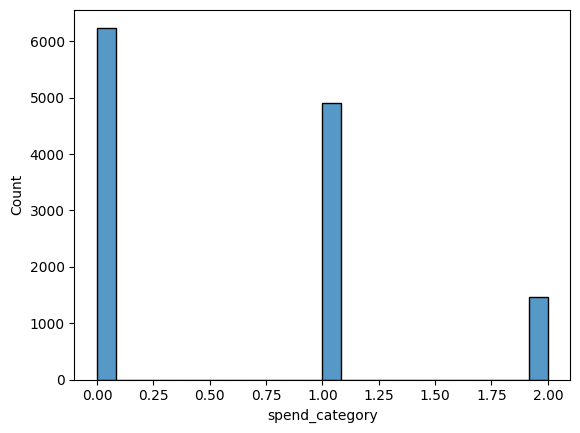

In [11]:
df = pd.read_csv('train.csv')
sns.histplot(df['spend_category'])